<a href="https://colab.research.google.com/github/Jholman22/TEORIA-DE-SENALES/blob/main/RuidosMetodosyGraficas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

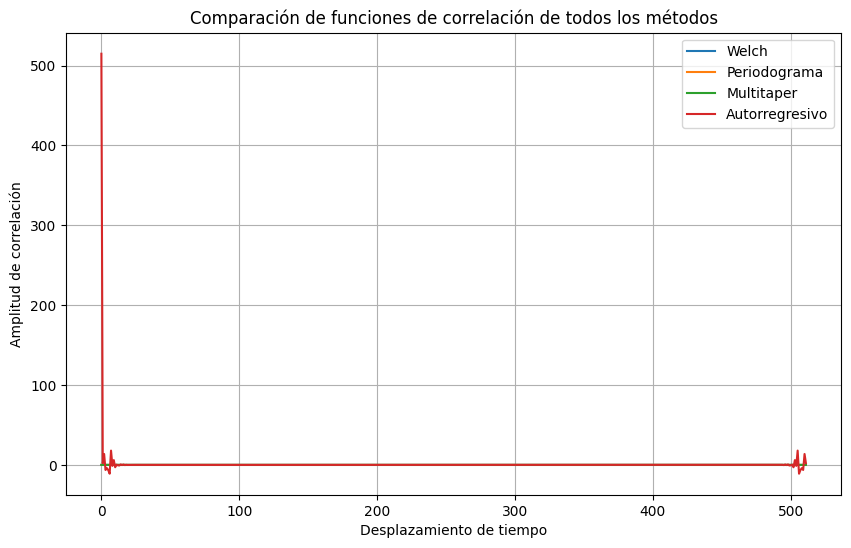

In [27]:
# Graficar todas las correlaciones en una sola figura
plt.figure(figsize=(10, 6))
for method, autocorr in correlaciones.items():
    plt.plot(autocorr[0], label=method)  # Graficar cada correlación
plt.xlabel('Desplazamiento de tiempo')
plt.ylabel('Amplitud de correlación')
plt.title('Comparación de funciones de correlación de todos los métodos')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig
from scipy.signal.windows import dpss
from scipy.linalg import toeplitz

class Ruidos:
    def __init__(self, T, n):  # Constructor
        self.T = T
        self.n = n
        self.ruido_blanco = np.random.randn(self.n, self.T)

    def mostrar_ruidos(self, num):  # Método para graficar ruido blanco
        for i in range(num):
            plt.plot(self.ruido_blanco[i])
            plt.title(f'Vector de ruido blanco {i+1}')
            plt.xlabel('Muestra')
            plt.ylabel('Amplitud')
            plt.grid(True)
        plt.show()


class MetodosPSD:
    def __init__(self, ruido, fs):  # Constructor
        self.ruido = ruido  # Matriz de ruido blanco (n vectores)
        self.fs = fs  # Frecuencia de muestreo
        self.n = ruido.shape[0]  # Número de vectores
        self.T = ruido.shape[1]  # Longitud de cada vector

    def welch_method(self, nperseg):  # Estimación PSD con Welch
        f_total = []
        Pxx_total = []
        for i in range(self.n):
            f, Pxx = sig.welch(self.ruido[i], self.fs, nperseg=nperseg)
            f_total.append(f)
            Pxx_total.append(Pxx)
        return f_total, Pxx_total

    def periodogram_method(self):  # Estimación PSD con Periodograma
        f_total = []
        Pxx_total = []
        for i in range(self.n):
            f, Pxx = sig.periodogram(self.ruido[i], self.fs)
            f_total.append(f)
            Pxx_total.append(Pxx)
        return f_total, Pxx_total

    def multitaper_method(self, NW):  # Estimación PSD con Multitaper
        f_total = []
        Pxx_total = []
        for i in range(self.n):
            # Generar tapers usando el método DPSS
            tapers, eigvals = dpss(self.T, NW, return_ratios=True)
            Pxx = np.zeros((len(tapers), self.T // 2 + 1))
            for j, taper in enumerate(tapers):
                f, Pxx_temp = sig.periodogram(self.ruido[i] * taper, self.fs)
                Pxx[j] = Pxx_temp
            Pxx_mean = np.mean(Pxx, axis=0)  # Promediar sobre todos los tapers
            f_total.append(f)
            Pxx_total.append(Pxx_mean)
        return f_total, Pxx_total

    def autorregresive_method(self, order):  # Estimación PSD con AR
        f_total = []
        Pxx_total = []
        for i in range(self.n):
            x = self.ruido[i]
            # Estimación de coeficientes AR usando Yule-Walker
            r = np.correlate(x, x, mode='full')[self.T - 1:]
            R = toeplitz(r[:order])
            r_right = r[1:order + 1]
            ar_coeffs = np.linalg.solve(R, r_right)
            error_var = r[0] - np.dot(ar_coeffs, r_right)

            # Cálculo de la PSD
            f = np.linspace(0, self.fs / 2, self.T // 2 + 1)
            psd = error_var / np.abs(1 + np.sum([ar_coeffs[k] * np.exp(-2j * np.pi * f * (k + 1) / self.fs)
                                                for k in range(order)], axis=0)) ** 2
            f_total.append(f)
            Pxx_total.append(psd)
        return f_total, Pxx_total

    def plot_psd(self, f_total, Pxx_total, method_name):  # Método para graficar PSD
        for i in range(len(f_total)):
            plt.plot(f_total[i], Pxx_total[i], label=f'Ruido {i+1}')
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Densidad espectral de potencia')
        plt.title(f'Estimación espectral con el método {method_name}')
        plt.grid(True)
        plt.show()

class Correlacion:
    def __init__(self, ruido):  # Constructor
        self.ruido = ruido  # Matriz de ruido blanco (n vectores)
        self.n = ruido.shape[0]  # Número de vectores
        self.T = ruido.shape[1]  # Longitud de cada vector

    def calcular_correlacion(self, metodo_psd):  # Cálculo de la correlación
        correlaciones = []
        for i in range(self.n):
            _, Pxx = metodo_psd[i]
            autocorr = np.fft.irfft(Pxx, n=self.T)  # Transformada inversa de Fourier
            correlaciones.append(autocorr)
        return correlaciones

    def graficar_correlacion(self, correlaciones, method_name):  # Graficar la correlación
        for i in range(len(correlaciones)):
            plt.plot(correlaciones[i])  # Graficar función de correlación
        plt.xlabel('Desplazamiento de tiempo')
        plt.ylabel('Amplitud de correlación')
        plt.title(f'Función de correlación con el método {method_name}')
        plt.grid(True)
        plt.show()


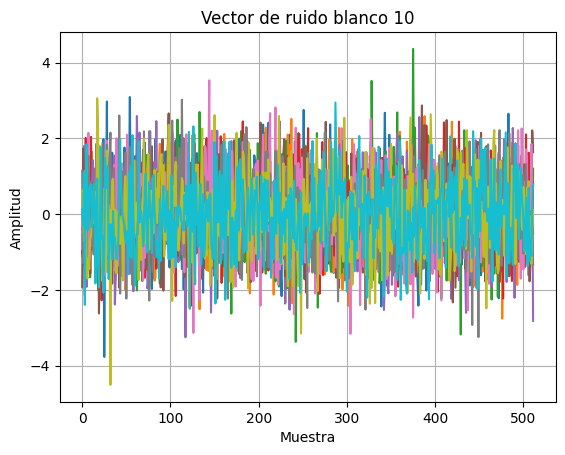

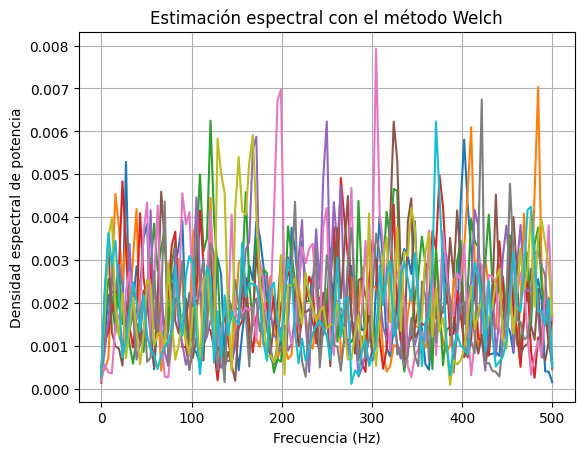

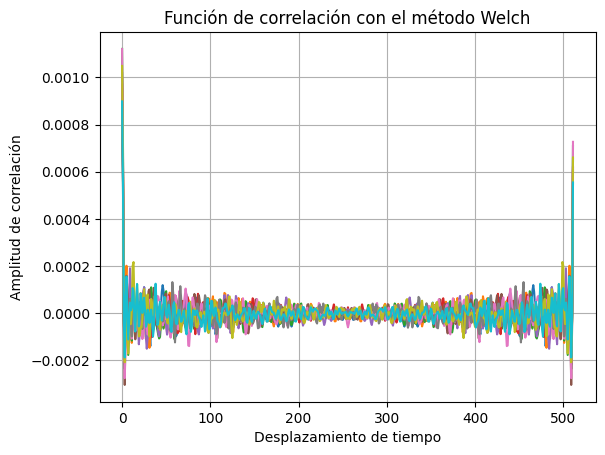

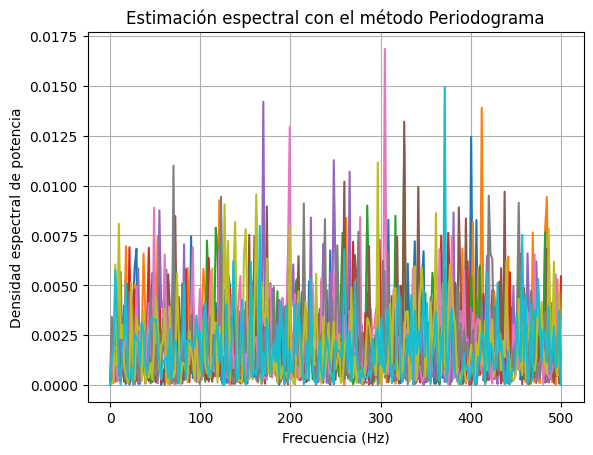

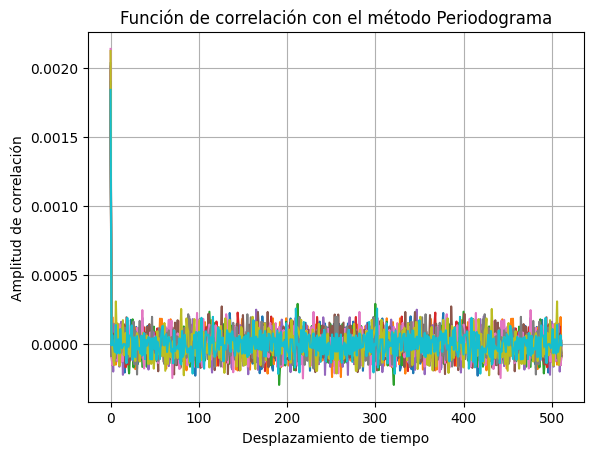

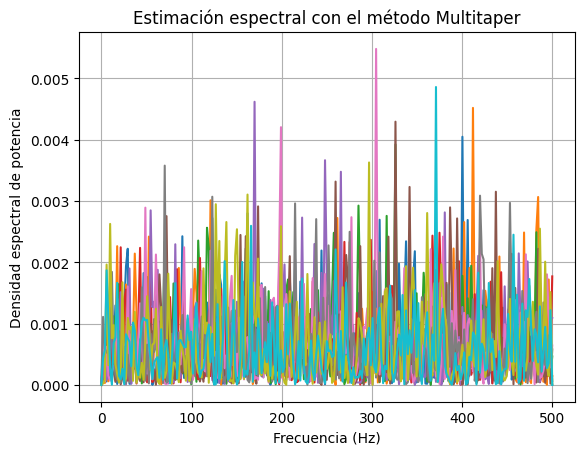

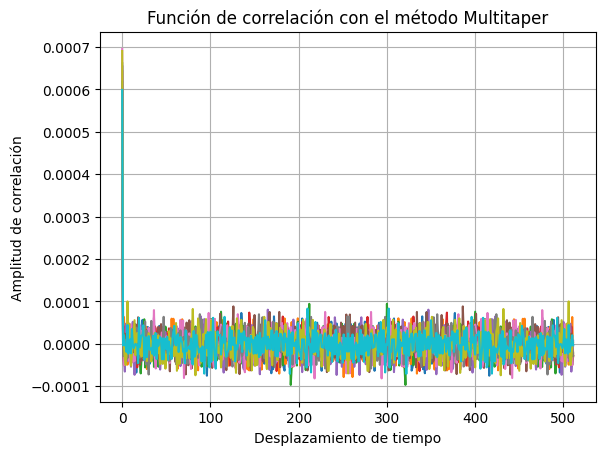

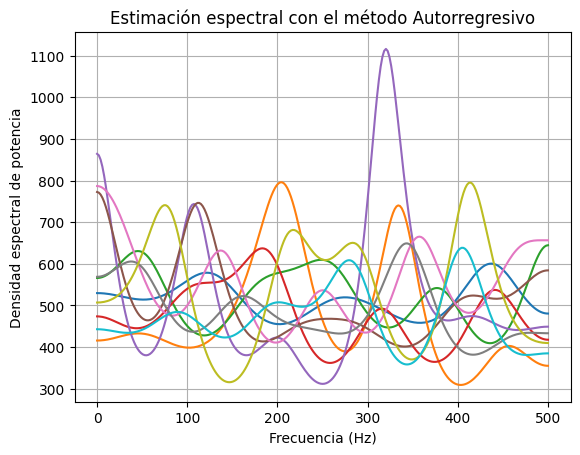

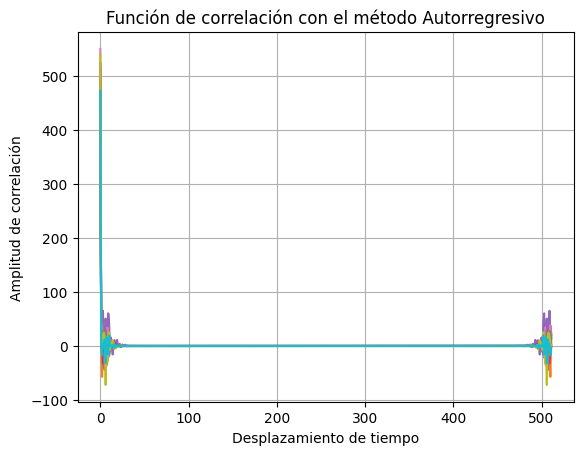

In [26]:
# Crear instancia de Ruidos
ruidos = Ruidos(T=512, n=10)  # Un solo vector para simplificar la comparación
ruidos.mostrar_ruidos(num=10)

# Crear instancia de MetodosPSD
fs = 1000  # Frecuencia de muestreo
metodos = MetodosPSD(ruidos.ruido_blanco, fs)

# Crear instancia de Correlacion
correlacion = Correlacion(ruidos.ruido_blanco)

# Inicializar contenedor de correlaciones y nombres de métodos
correlaciones = {}
method_names = ["Welch", "Periodograma", "Multitaper", "Autorregresivo"]

# Welch
nperseg = 256
f_welch, Pxx_welch = metodos.welch_method(nperseg)
metodos.plot_psd(f_welch, Pxx_welch, method_name="Welch")
correlaciones["Welch"] = correlacion.calcular_correlacion(list(zip(f_welch, Pxx_welch)))
correlacion.graficar_correlacion(correlaciones["Welch"], method_name="Welch")


# Periodograma
f_periodogram, Pxx_periodogram = metodos.periodogram_method()
metodos.plot_psd(f_periodogram, Pxx_periodogram, method_name="Periodograma")
correlaciones["Periodograma"] = correlacion.calcular_correlacion(list(zip(f_periodogram, Pxx_periodogram)))
correlacion.graficar_correlacion(correlaciones["Periodograma"], method_name="Periodograma")

# Multitaper
NW = 2.5
f_multitaper, Pxx_multitaper = metodos.multitaper_method(NW)
metodos.plot_psd(f_multitaper, Pxx_multitaper, method_name="Multitaper")
correlaciones["Multitaper"] = correlacion.calcular_correlacion(list(zip(f_multitaper, Pxx_multitaper)))
correlacion.graficar_correlacion(correlaciones["Multitaper"], method_name="Multitaper")

# Autorregresivo
order = 10
f_ar, Pxx_ar = metodos.autorregresive_method(order)
metodos.plot_psd(f_ar, Pxx_ar, method_name="Autorregresivo")
correlaciones["Autorregresivo"] = correlacion.calcular_correlacion(list(zip(f_ar, Pxx_ar)))
correlacion.graficar_correlacion(correlaciones["Autorregresivo"], method_name="Autorregresivo")
